# TP4: Different denoising architectures

### Name: **Elías MASQUIL**


In this lesson we will use the *layer inspector* tools for inspecting the intermediate state of a multiscale denoising network called U-Net.  Then, we will go back to self-supervised methods to study noise2self.

We will cover the following topics:
* U-Net architecture - with and without skip connections
* What can we see by applying the layer inspector to U-net?
* Noise2Seft training 
* [Deep image prior (another notebook)](https://colab.research.google.com/drive/1jqacuFh4I34MEVFGcBjJaT7kyZGOO5VB)

There are **5 questions** in the notebook and corresponding text areas to fill-in the answers. 


#### Instructions
To solve this TP, answer the questions below. Then export the notebook with the answers using  the menu option **File->Download .ipynb**. Then **[submit your solution here](https://docs.google.com/forms/d/e/1FAIpQLScQZ6QQvsdihV5NqNBeVe35Cg1MnvjFFNum7o-v8Ody6dhpVA/viewform)** by 1/12/2021.  You will receive an acknowledgement of receipt.

In [ ]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run' 
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output. Something similar 
# applies to the next two or three cells. They only define 
# functions that are used later.


# This notebook can also run on colab (https://colab.research.google.com/)
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install hdf5storage

    !rm -fr MVAdenoising
    !git clone  https://github.com/gfacciol/MVAdenoising
    !cp -r MVAdenoising/* .

except ImportError:
    # %matplotlib notebook
    pass


# These are all the includes used through the notebook
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import vistools          # image visualization toolbox
from   skimage import io # read and write images
from   vistools import unzip


# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = None
else:
    loadmap = {'cuda:0': 'cpu'}
    
    

#%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

persistent_storage = 'trainings/'


     |████████████████████████████████| 53 kB 1.3 MB/s 
Cloning into 'MVAdenoising'...
remote: Enumerating objects: 921, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 921 (delta 38), reused 27 (delta 27), pack-reused 866
Receiving objects: 100% (921/921), 262.39 MiB | 13.84 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Checking out files: 100% (607/607), done.


**Persistent storage.** The current notebook runs on a virtual machine with sessions limited 24h. After that all the content of the session (state and files) is removed. So  a persistent storage must be connected to the virtual machine in order to store the results.

The following code  connects a google drive account to the virtual machine.

In [ ]:
# this cell connects the persistent storage

persistent_storage = 'trainings/'
try:
    # Load the Drive helper and mount
    from google.colab import drive
    import os

    # This will prompt for authorization.
    drive.mount( 'Drive')
    persistent_storage = 'Drive/My Drive/CNN_trainings/'
    os.makedirs(persistent_storage, exist_ok=True)
except:
    pass

Mounted at Drive


# U-Net

We will now study the U-Net instroduced in the context of image segmentation in

      O. Ronneberger, P. Fischer, T. Brox, "U-Net: Convolutional Networks for 
      Biomedical Image Segmentation," Medical Image Computing and
      Computer-Assisted Intervention (MICCAI), Springer, LNCS, 2015
 

and used often in the context of image restoration (e.g. [C. Chen, Q. Chen, J. Xu, V. Koltun, "Learning to See in the Dark."](https://arxiv.org/abs/1805.01934))
 
The U-Net has a U-shaped architecture as illustrated below:

<img width=500 src="https://raw.githubusercontent.com/gfacciol/MVAdenoising2018/master/models/unet.png"/>

The definition of our U-Net is `models.UNet`. The following code trains it (or loads a pre-trained one).

In [ ]:
from torch import nn
from models import UNet
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel


sigma=30

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False


# choose loss
#loss_name = 'l1'
loss_name = 'l2'

if training:
    
    # data
    trainloader, valloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=128, 
                                               train_batch_size=45 )

    # network model
    denoiser = UNet(1,1)    

    # run the training loop using chosen loss
    loss_fn = nn.L1Loss() if loss_name == 'l1' else nn.MSELoss()
    denoiser, losst, lossv, = trainmodel(denoiser, loss_fn, trainloader, valloader, 
                                         num_epochs=2000, save_every=500, loss_every=10,  
                                         learning_rate=0.001, weight_decay=0.00001,
                                         filename='pre-trained-tp3/Unet_%s_' % (loss_name))

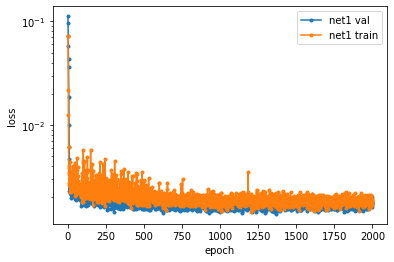


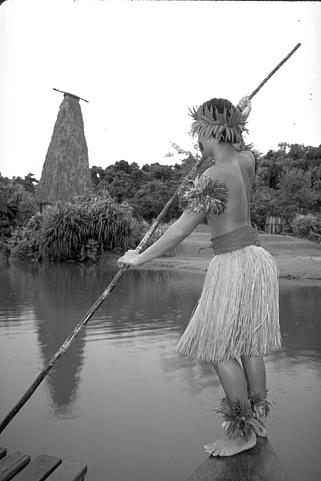
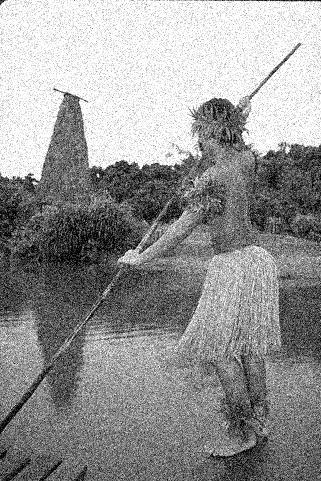
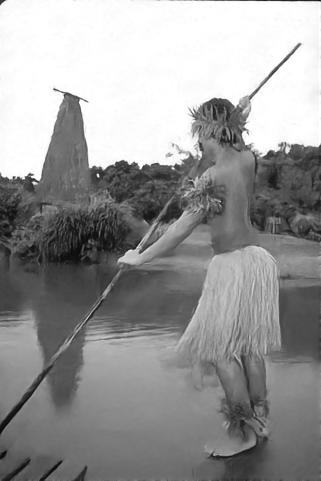

In [ ]:
from skimage import io
import torch
from models import UNet
from denoising_helpers import test_denoiser

denoiser, losst, lossv = torch.load('pre-trained-tp3/Unet_l2_2000.pt', map_location=loadmap)
denoiser.cpu()

plt.semilogy(lossv, '.-', label='net1 val')
plt.semilogy(losst, '.-', label='net1 train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');
plt.show()

img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)

_ = test_denoiser(denoiser, img_clean, sigma=30, show=True)




<!--**Question 2.** 
In the block below, write the code needed for comparing the performance of U-Net with DnCNN, and FFDNet. Compare speed, PSNR, and visual quality. 

**Tips**
* Follow the comments below and re-use code from other blocks (from previous TPs)
* To measure the execution time you can use the command :  ```%timeit  output = command(input)```-->

**The block below compares the result of the UNet trained for 2000 epochs with DnCNN and FFdNet.**

downloading pretrained models
downloading pretrained models



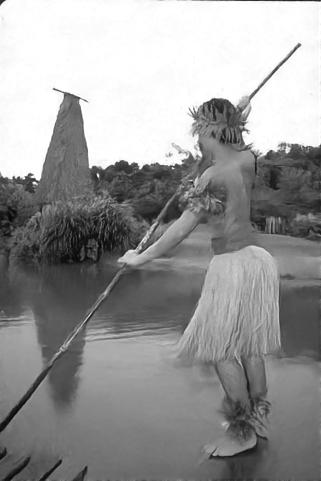
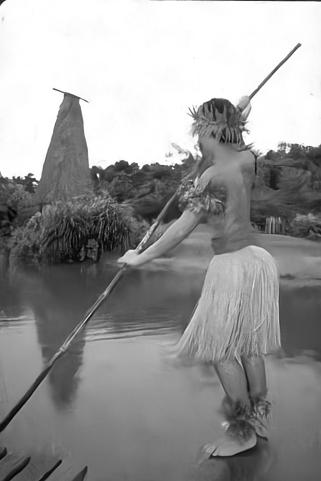
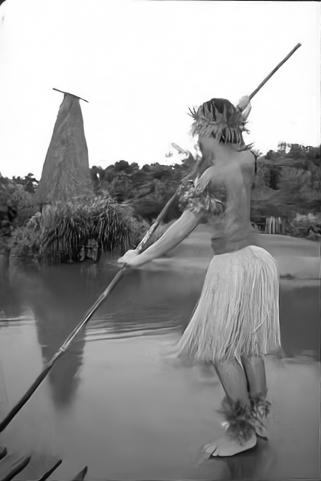

In [ ]:
###############################
###                         ###
###############################

from skimage import io
import torch
from models import UNet, DnCNN_pretrained, DnCNN, FFDNet_pretrained_grayscale, FFDNet
from denoising_helpers import test_denoiser, PSNR

sigma = 30

# load image
im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32) 
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

# list of labelled results to display as gallery
outputs = list()


# let's load U-Net first ###############################################

# load network
denoiser = torch.load( 'pre-trained-tp3/Unet_l2_2000.pt' )[0]
denoiser.cpu()
    
# denoise image with loaded net
out = test_denoiser(denoiser, im_noisy, None, has_noise=True)[0] 
outputs.append( (out, 'U-Net - PSNR = %f' %(PSNR(out, im_clean))) )    

# now test DnCNN_pretrained #################################
    
# load network
denoiser = DnCNN_pretrained() 
denoiser.cpu()
    
# denoise image with loaded net
out = test_denoiser(denoiser, im_noisy, None, has_noise=True)[0] 
outputs.append( (out, 'DnCNN - PSNR = %f' %(PSNR(out, im_clean))) )    

    
# finally FFDNet_pretrained_grayscale #################################
    
# load network
denoiser = FFDNet_pretrained_grayscale() 
denoiser.cpu()
    
# denoise image with loaded net
out = test_denoiser(denoiser, im_noisy, None, has_noise=True)[0] 
outputs.append( (out, 'FFDNet - PSNR = %f' %(PSNR(out, im_clean))) )    

    
# show as a gallery
vistools.display_gallery(unzip(outputs,0), unzip(outputs,1))

# Layer inspector for U-Net

In the last class we introduced layer inspectors to see the intermediate results for the hidden layers of a network. We defined a layer inspector as a simple affine transformation that transforms the hidden features into an output image. For DnCNN, each layer inspectors were $1\times 1$ convolutional layers, which were trained *after* DnCNN was trained.

U-Net downscales the image through the network. To inpect these downscaled layers, we need our inpectors to up-scale them. One way of doing that is by transposing a convolutional layer with a stride. A convolutional layer with a stride of 2, produces an output which is half the size of the input. Thus by transposing it, we produce an output which has twice the input size.

In the next block we define our `UNetInspector` module. It attaches one inspector layer for each scale. In the scales that have skip connections, we attach the inspector *before* upscaling, as shown in the diagram: 

<img width=500 src="https://github.com/gfacciol/MVAdenoising2018/blob/master/models/unetInspector.png?raw=1"/>

**<font color=red size=12pt>Attention the following code only works with images with size multiple of 16!</font>**

In [ ]:
from models import UNet

class UNetInspector(nn.Module):
    def __init__(self, unet, trainall=False):
        """
        Args: 
            - unet: a unet network
            - trainall: train the unet? (default False)
        """
        super(UNetInspector, self).__init__()
            
        # retrieve parameters of unet network ?? any
        self.n_channels   = unet.outc.conv.weight.shape[0] 
        self.trainall  = trainall # train the UNET 

        import copy
        self.unet = copy.deepcopy(unet)
        
        # we don't want to train the unet parameters
        if not trainall:
            for p in self.unet.parameters():
                p.requires_grad = False
        
        # define inspector layers
        self.inspectors = []
        

        # then add the other inspectors from higher to lower resolutions
        ss = [2,4,8,16]  # strides
        kk = [4,8,16,32] # kernel sizes
        pp = [1,2,4,8]   # padding
        ff = [64, 128, 256, 512]   # features
        for i in range(4):            
#            nfeatures = min(pow(2,i)*64,512)  # DEBUG
#           print(nfeatures, pow(2,i))         # DEBUG
            self.inspectors.append( nn.ConvTranspose2d(
                                      ff[i], self.n_channels, 
                                      kk[i], stride=ss[i], 
                                      padding=pp[i] ) )
            
            name = 'inspector%d' % i
            self.register_parameter(name + 'weight', self.inspectors[i].weight)
            self.register_parameter(name + 'bias'  , self.inspectors[i].bias)

            
            
        i = 4
        # first add sanity check inspector at the end of the network
        self.inspectors.append( nn.Conv2d(
                                  64, self.n_channels, 
                                  3, padding=1 ) )
        
        name = 'inspector%d' % i
        self.register_parameter(name + 'weight', self.inspectors[i].weight)
        self.register_parameter(name + 'bias'  , self.inspectors[i].bias)  
        
                
        
    def forward(self, x):
        """
        """
        
        # force eval mode in dncnn network
        if not self.trainall:
            self.unet.eval()

        outputs = []        
                
        x1 = self.unet.inc(x)
        x2 = self.unet.down1(x1)
        x3 = self.unet.down2(x2)
        x4 = self.unet.down3(x3)
        
        x5 = self.unet.down4(x4)
        outputs.append( self.inspectors[3](x5) ) 

        x = self.unet.up1(x5, x4)
        outputs.append( self.inspectors[2](x) ) 

        x = self.unet.up2(x, x3)
        outputs.append( self.inspectors[1](x) ) 

        x = self.unet.up3(x, x2)        
        outputs.append( self.inspectors[0](x) ) 

        x = self.unet.up4(x, x1)
        outputs.append( self.inspectors[4](x) ) 
        
        x = self.unet.outc(x)
        
        outputs.append( x ) 

        # returns a tensor having all the produced outputs as channels
        # the number of channels is (num_layers-1)*ch, where ch is the 
        # number of channels of x
        return torch.cat(outputs,-3)


To train the inspectors we need a custom loss (because the inspector network produces multiple output images). The following block defines our `multiOutputMSELoss`. Our loss will be the MSE between the images produced by each inspector and the clean image:
$$R^{\text{emp}}(\theta) = \frac 1{L-1}\sum_i \sum_{l=1}^{l = L-1} \|\mathcal I^l_\theta(\mathcal F^l(u)) - \widetilde u\|^2.$$
The parameters $\theta$ here are the weights and biases of each inspector.

In [ ]:

# we define this loss, so that we can train all inspectors in parallel
def multiOutputMSELoss(x, y):
    """
    Computes the average MSE loss multiple outputs x_1, ...., x_n with respect
    to a single target y.
    
    Args:
        - x: outputs, 4D tensor of size [b, n*ch, w, h] where b is the batch size, n is
             the number of ouputs, ch is the number of channels of each output and wxh
             their spatial dimension
        - y: target, 4D tensor of size [b, ch, w, h]
    
    Returns:
        - loss: average MSE loss, i.e. 1/n * \sum_i MSELoss(x_i,y)
    """
    
    if x.shape[-3] % y.shape[-3] != 0:
        print('multiOutputMSELoss: x num. of channels is not a multiple of y num. of channels')
    n = x.shape[-3]//y.shape[-3]
    
    return ((x - torch.cat([y]*n,1))**2).mean()

We now train and apply the inspector networks.

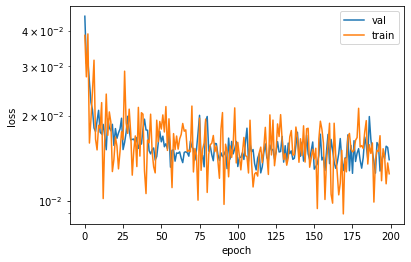

In [ ]:
# train layer inspectors by minimizing the multi output MSE loss

from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import DnCNN

sigma=30


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False


if training:
    # data
    trainloader, valloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=128, 
                                               train_batch_size=32)

    # load a dncnn network, and build an inspector for it
    denoiser, trainloss, valloss = torch.load('pre-trained-tp3/Unet_l2_2000.pt', map_location=loadmap)
    denoiser_ins = UNetInspector(denoiser)
    ## this can be used to train the whole network with the multiscale loss
    #denoiser_ins = UNetInspector(denoiser, trainall=True)
    
    
    
    # run the training loop
    denoiser_ins, losst, lossv, = trainmodel(denoiser_ins, multiOutputMSELoss, trainloader, valloader, 
                                             num_epochs=200, save_every=100, loss_every=10,  
                                             learning_rate=0.01, weight_decay=0.0,
                                             filename='pre-trained-tp3/layer_inspector_Unet_')

else:
    denoiser_ins, losst, lossv = torch.load('pre-trained-tp3/layer_inspector_Unet_0200.pt', map_location=loadmap)

# plot loss
plt.semilogy(lossv, label='val')
plt.semilogy(losst, label='train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');


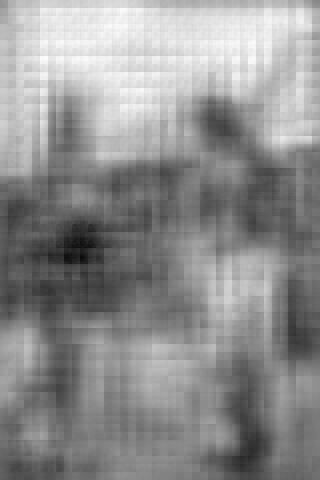
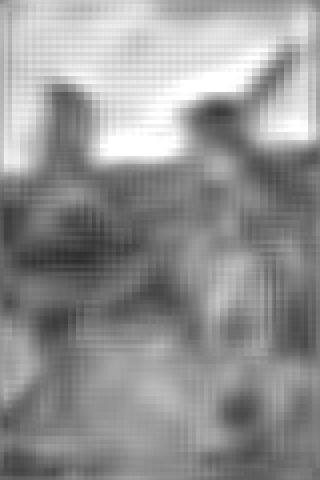
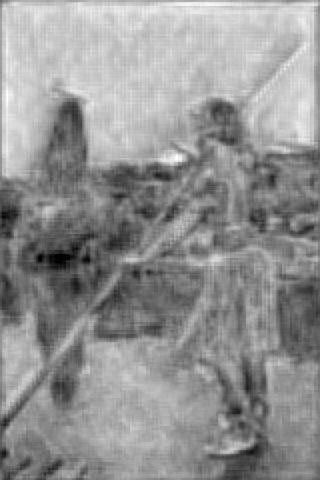
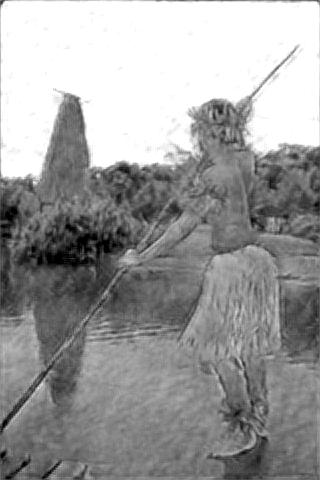
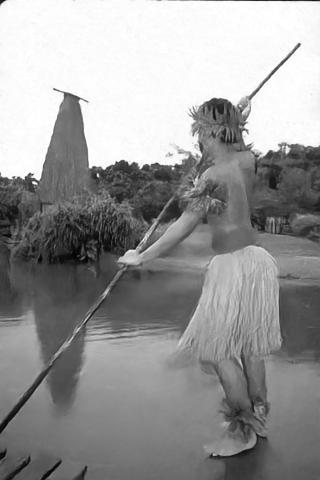
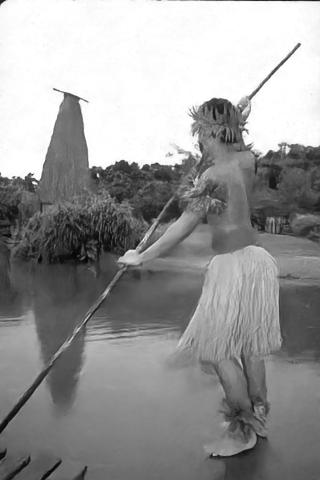
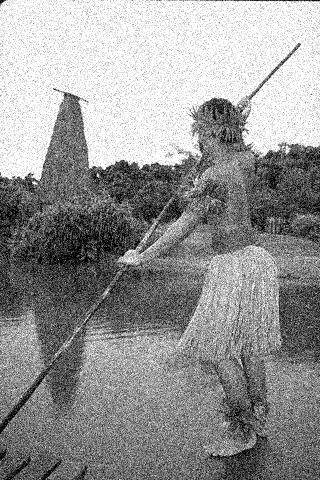

In [ ]:
from models import DnCNN_pretrained
from skimage import io
from denoising_helpers import PSNR
from vistools import unzip

# test it with a noisy image
sigma=30

im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)[0:480,0:320]  #<<<<< HERE WE FOCE THE SHAPE

# put the image in the range [0,1] and add noise
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)
im_noisy = im_noisy.astype('float32') / 255.

# create inpector from existing dncnn
denoiser_ins = torch.load('pre-trained-tp3/layer_inspector_Unet_0200.pt', map_location=loadmap)[0]

# torch data type
dtype = torch.FloatTensor
if torch.cuda.is_available():
    # run on GPU
    denoiser_ins = denoiser_ins.cuda()
    dtype = torch.cuda.FloatTensor

# set denoising network in evaluation (inference) mode
denoiser_ins.eval()

# apply inspector network
with torch.no_grad(): # tell pytorch that we don't need gradients
    img = dtype(im_noisy[np.newaxis,np.newaxis,:,:]) # convert to tensor
    out = denoiser_ins(img).cpu()

outs = []
for i in range(out.shape[1]):
    outs.append( (out[0,i,:,:]*255, 'inspector %d - %f (dB)' % (i, PSNR(out[0,i,:,:]*255, im_clean)) ) )

outs.append( (im_noisy*255, 'noisy - %f (dB)' % (PSNR(im_noisy, im_clean)) ) )

vistools.display_gallery(unzip(outs,0), unzip(outs,1))

<font color='blue'>**Question 1.** 
Comment on the result of the above experiment. Does the result correspond to your expectactions? </font>

<font color='red'>**ANSWER TO QUESTION 1.**</font>

Yes. There is a significative jump in the PSNR after inspector 2, which corresponds to the second step in which there are skip connections. After that layer one can expect that information from different scales is being used for denoising the image. That might explain the good results. Also, it's the first layer in which the artifacts produced by upscalling a small (but deep) image aren't noticable. In previous layers the denoised image obtained with the inspector is not at all acceptable because it's not using information from different scales, and more importantly, it's being upscaled from a tiny image. Finally, the last two layers are producing almost the same great results, it seems that a last denoising step, in which small details are being fixed, is happening in the last layer.

# U-Net without skip connections

To understand the importance of skip connections, we will train a network without them:

<img width=500 src="https://github.com/gfacciol/MVAdenoising2018/blob/master/models/unetX.png?raw=1"/>

In [ ]:
from torch import nn
from models import UNet
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel



sigma=30

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False


# choose loss
#loss_name = 'l1'
loss_name = 'l2'

if training:
    
    # data
    trainloader, validationloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=128, 
                                               train_batch_size=45 )

    # network model without skip connections
    denoiser =  UNet(1,1, skipc=False)

    # run the training loop using chosen loss
    loss_fn = nn.L1Loss() if loss_name == 'l1' else nn.MSELoss()
    denoiser, losst, lossv, = trainmodel(denoiser, loss_fn, trainloader, validationloader, 
                                         num_epochs=2000, save_every=250, loss_every=10,  
                                         learning_rate=0.001, weight_decay=0.00001,
                                         filename='pre-trained-tp3/Unet_noskip_%s_' % (loss_name))

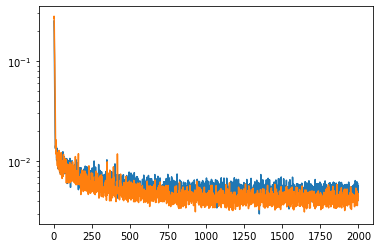


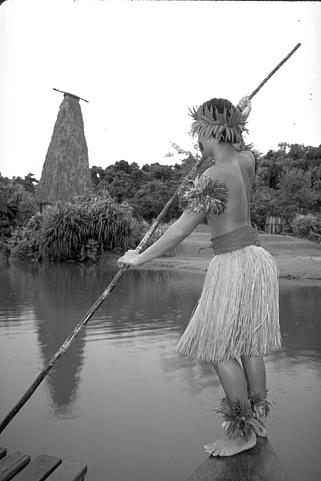
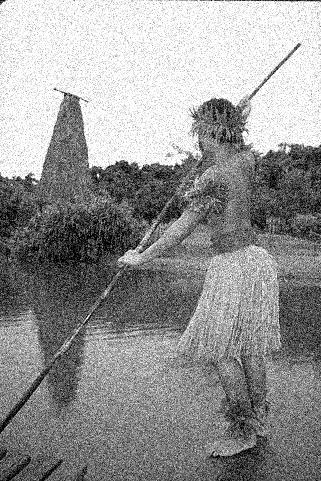
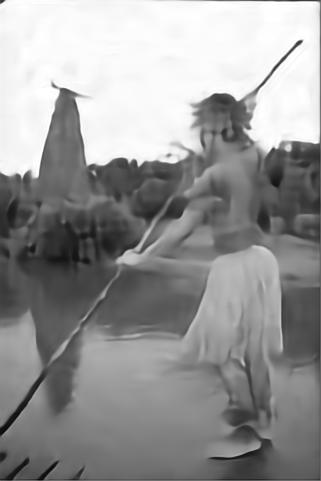

In [ ]:
from skimage import io
import torch
from models import UNet
from denoising_helpers import test_denoiser


denoiser, losst, lossv = torch.load('pre-trained-tp3/Unet_noskip_l2_2000.pt', map_location=loadmap)
plt.semilogy(losst[0:])
plt.semilogy(lossv[0:])

plt.show()



import vistools


img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
#img_clean = io.imread('datasets/LIVE1/bikes.bmp', dtype='float32')[:,:,1]

_ = test_denoiser(denoiser, img_clean, sigma=30, show=True)

This result shouldn't be too surprising. Let's look at the inspectors for the U-Net without skip connections.

<font color='blue'>**Question 2.** What is the impact of removing the skip connections? Provide an explanation for this.
</font>

<font color='red'>**ANSWER TO QUESTION 2.**</font>

The removal of skip connections creates a bottleneck in the model. This bottleneck "forces" the model to reconstruct the image from a lower dimension space (like an autoencoder), and then we get a denoised but overly-smooth result.

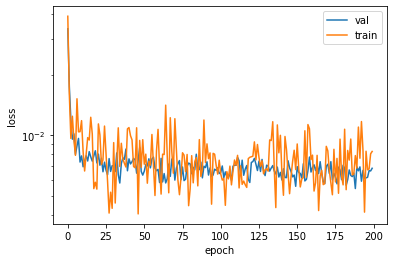

In [ ]:
# train layer inspectors by minimizing the multi output MSE loss

from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import UNet

sigma=30


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False


if training:
    # data
    trainloader, valloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=128, 
                                               train_batch_size=32)

    # load a dncnn network, and build an inspector for it
    denoiser, trainloss, valloss = torch.load('pre-trained-tp3/Unet_noskip_l2_2000.pt', map_location=loadmap)
    denoiser_ins = UNetInspector(denoiser)

    # run the training loop
    denoiser_ins, losst, lossv, = trainmodel(denoiser_ins, multiOutputMSELoss, trainloader, valloader, 
                                             num_epochs=200, save_every=100, loss_every=10,  
                                             learning_rate=0.01, weight_decay=0.0,
                                             filename='pre-trained-tp3/layer_inspector_Unet_noskip_')

else:
    denoiser_ins, losst, lossv = torch.load('pre-trained-tp3/layer_inspector_Unet_noskip_0200.pt', map_location=loadmap)

# plot loss
plt.semilogy(lossv, label='val')
plt.semilogy(losst, label='train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');


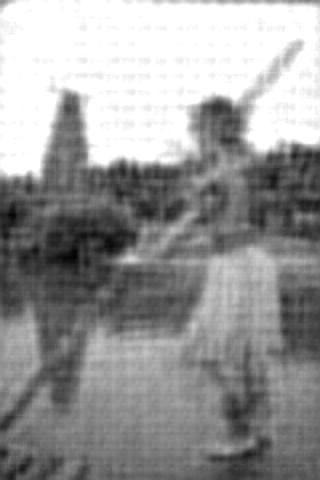
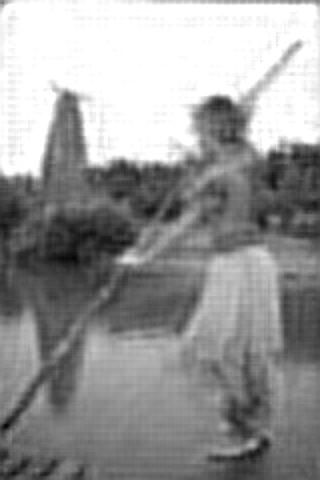
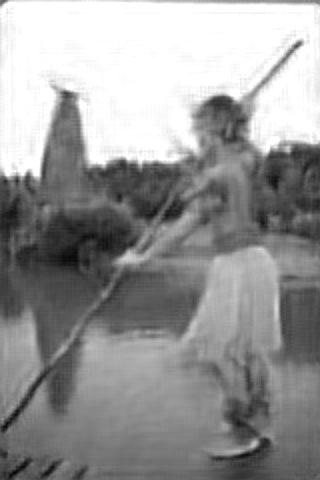
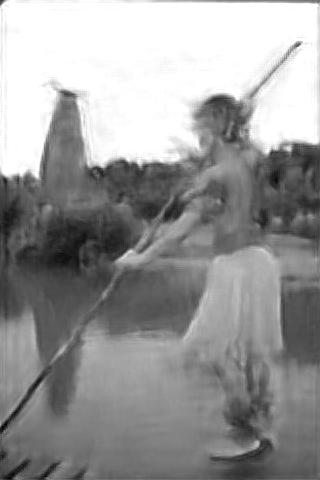
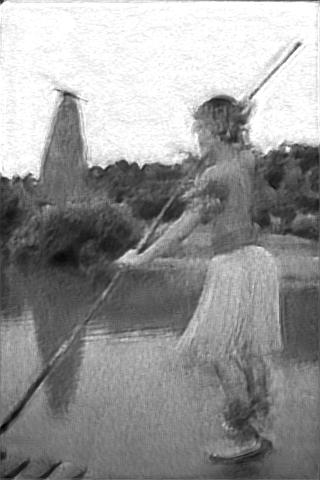
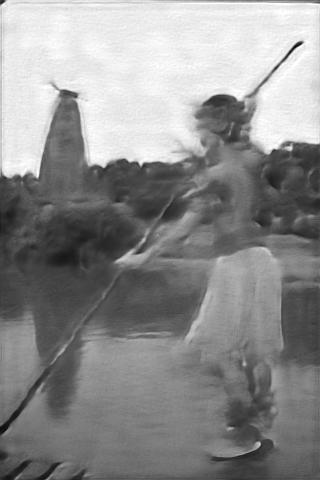
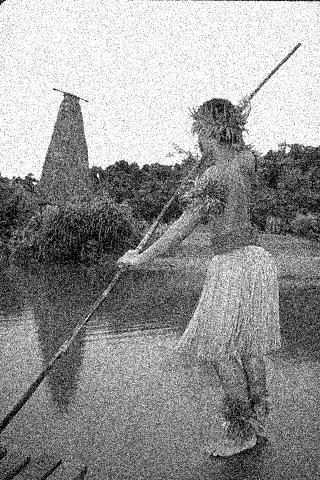

In [ ]:
from models import DnCNN_pretrained
from skimage import io
from denoising_helpers import PSNR
from vistools import unzip

# test it with a noisy image
sigma=30
im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)[0:480,0:320]

# put the image in the range [0,1] and add noise
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)
im_noisy = im_noisy.astype('float32') / 255.

# create inpector from existing dncnn
denoiser_ins = torch.load('pre-trained-tp3/layer_inspector_Unet_noskip_0200.pt', map_location=loadmap)[0]

# torch data type
dtype = torch.FloatTensor
if torch.cuda.is_available():
    # run on GPU
    denoiser_ins = denoiser_ins.cuda()
    dtype = torch.cuda.FloatTensor

# set denoising network in evaluation (inference) mode
denoiser_ins.eval()

# apply inspector network
with torch.no_grad(): # tell pytorch that we don't need gradients
    img = dtype(im_noisy[np.newaxis,np.newaxis,:,:]) # convert to tensor
    out = denoiser_ins(img).cpu()

outs = []
for i in range(out.shape[1]):
    outs.append( (out[0,i,:,:]*255, 'inspector %d - %f (dB)' % (i, PSNR(out[0,i,:,:]*255, im_clean)) ) )

outs.append( (im_noisy*255, 'noisy - %f (dB)' % (PSNR(im_noisy, im_clean)) ) )

vistools.display_gallery(unzip(outs,0), unzip(outs,1))

<font color='blue'>**Question 3.** 
- Compare these results with the outputs of inpectors for the U-Net (with the skip connections). In which case does the output of the inspectors at the coarse layers resemble more a low resolution version of the image?
- Advance an hypothesis for this behavior.
</font>

<font color='red'>**ANSWER TO QUESTION 3.**</font>

* We observe a similar behavior as with the U-Net, the first layers produce low detail verions of the image, so the reconstruction improves as we go deeper in the network. I find the coarse layers on the U-Net to generate an output more similar to a low resolution version of the image.

* The U-Net is designed to create this multi-scale representation of the image, while the DnCNN is just a convolutional model which works on a single scale. It seems reasonable to have closer representations to a multi-scale image using a U-Net.

# Noise2Self training

Noise2self is a framework for self-supervised denoising proposed in  

      J. Batson and L. Royer, “Noise2Self: Blind Denoising by Self-Supervision,” ICML, 2019.

For the TP, we are going to implement a simplified version of N2S. It's core idea is to hide some noisy pixels of the image $u$ with a random binary mask ($M$) at the input of the network and use them as targets for a noise2noise type training:

$$ \|  M \cdot \mathcal F ( (1-M)  \cdot u)   -   M \cdot u   \|.$$ 

The binary mask changes from image to image, so the network must learn to predict the missing pixels. The easyest way to implement noise2self is changing the training function as below. 

In [ ]:


# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = None
else:
    loadmap = {'cuda:0': 'cpu'}

In [ ]:
from training import check_accuracy

def maskdata(X, fraction=1./25):
    """ mask a random fraction (1/25 by default) of the data X
    returns the masked data a map of the masked pixels (1 if masked)"""
    invmask = (torch.rand_like(X) > fraction )*1.0
    Xmasked =  X *invmask + torch.rand_like(X)*(1.0 - invmask)
    mask = torch.ones_like(X) - invmask
    return Xmasked, mask



def trainmodel_noise2self(model, loss_fn, loader_train, loader_val=None,
               optimizer=None, scheduler=None, num_epochs = 1,
               learning_rate=0.001, weight_decay=0.0, loss_every=10,
               save_every=10, filename=None, val_loss_fn=None):
    """
    function that trains a network model
    Args:
        - model       : network to be trained
        - loss_fn     : loss functions
        - loader_train: dataloader for the training set
        - loader_val  : dataloader for the validation set (default None)
        - optimizer   : the gradient descent method (default None)
        - scheduler   : handles the hyperparameters of the optimizer
        - num_epoch   : number of training epochs
        - save_every  : save the model every n epochs
        - filename    : base filename for the saved models
        - loss_every  : print the loss every n epochs
        - learning_rate: learning rate (default 0.001)
        - weight_decay: weight decay regularization (default 0.0)
        - val_loss_fn : if set, indicates validation loss function, otherwise uses loss_fn 
    Returns:
        - model          : trained network
        - loss_history   : history of loss values on the training set
        - valloss_history: history of loss values on the validation set
    """
    import torch
    from time import time
    import numpy as np

    # if not set validation loss is loss_fn
    if val_loss_fn == None:
        val_loss_fn = loss_fn
        
    dtype = torch.FloatTensor
    # GPU
    if torch.cuda.is_available():
        model   = model.cuda()
        try:
            loss_fn = loss_fn.cuda()
            val_loss_fn = val_loss_fn.cuda()
        except:
            pass
        dtype   = torch.cuda.FloatTensor

    if optimizer == None or scheduler == None:
        # Default optimizer and scheduler

        # The optimizer is in charge of updating the parameters
        # of the model. It has hyper-parameters for controlling
        # the gradient update, such as the learning rate (lr) and
        # the regularization such as the weight_decay
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                                     betas=(0.9, 0.999), eps=1e-08,
                                     weight_decay=weight_decay, amsgrad=False)

        # The learning rate scheduler monitors the evolution of the loss
        # and adapts the learning rate to avoid plateaus. We will use
        # a scheduler available in torch that reduces the lr by 'factor'
        # if in the last epochs there hasn't been a significant
        # reduction of the validation loss
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                            mode='min', factor=0.5, patience=50,
                            mode='min', factor=0.8, patience=50,
                            verbose=True, threshold=0.0001,
                            threshold_mode='rel', cooldown=0,
                            min_lr=0, eps=1e-08)

    loss_history=[]
    valloss_history=[]
    
    # Display initial training and validation loss
    message=''
    if loader_val is not None:
        valloss = check_accuracy(model, val_loss_fn, loader_val)
        message = ', val_loss = %.4f' % valloss.item()

    print('Epoch %5d/%5d, ' % (0, num_epochs) +
          'loss = %.4f%s'% (-1, message))

    # Save initial results
    if filename:
        torch.save([model, loss_history, valloss_history],
                   filename+'%04d.pt' % 0)

    # Main training loop
    for epoch in range(num_epochs):

        # The data loader iterates once over the whole data set
        for (x, y) in loader_train:
            # make sure that the models is in train mode
            model.train()

            # Apply forward model and compute loss on the batch
            x = x.type(dtype) # Convert data into pytorch 'variables'
            y = y.type(dtype) # for computing the backprop of the loss


            # generate a mask for this data
            masked_fraction = 1.0/25
            x_invmask, mask = maskdata(x, masked_fraction)

            y_pred = model(x_invmask)
            # compute the loss and compensate for the missing pixels 
            loss = loss_fn(y_pred*mask, x*mask) / masked_fraction 


            # Zero out the gradients of parameters that the optimizer
            # will update. The optimizer is already linked to the
            # network parameters.
            optimizer.zero_grad()

            # Backwards pass: compute the gradient of the loss with
            # respect to all the learnable parameters of the model.
            loss.backward()

            # Update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        # Store loss history to plot it later
        loss_history.append(loss)
        if loader_val is not None:
            valloss = check_accuracy(model, val_loss_fn, loader_val)
            valloss_history.append(valloss)

        # Display current loss and compute validation loss
        if ((epoch + 1) % loss_every == 0):
            message=''
            if loader_val is not None:
                message = ', val_loss = %.4f' % valloss.item()

            print('Epoch %5d/%5d, ' % (epoch + 1, num_epochs) +
                  'loss = %.4f%s'% (loss.item(), message))

        # Save partial results
        if filename and ((epoch + 1) % save_every == 0):
            torch.save([model, loss_history, valloss_history],
                       filename+'%04d.pt' % (epoch + 1))
            print('Epoch %5d/%5d, checkpoint saved' % (epoch + 1, num_epochs))

        # scheduler update
        scheduler.step(loss.data)

    # Save last result
    if filename:
        torch.save([model, loss_history, valloss_history],
                    filename+'%04d.pt' % (epoch + 1))

    return model, loss_history, valloss_history

In [ ]:
from models import DnCNN
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from torch import nn
import torch

p=30

loss_name = 'l1'
#loss_name = 'l2'

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training: 
    # data
    train_loader, val_loader = train_val_denoising_dataloaders(
                                              './datasets/Train400/',
                                               noise_sigma=p, crop_size=40, 
                                               train_batch_size=128,
                                               noise_type='gaussian')

    # network model
    dncnn = DnCNN(in_channels=1, out_channels=1, 
                  num_layers=7, features=13, kernel_size=3, residual=True)

    # run the training loop
    loss = nn.L1Loss() if loss_name == 'l1' else nn.MSELoss()
    dncnn, losst, lossv = trainmodel_noise2self(dncnn, loss, train_loader, val_loader, 
                                    num_epochs=8000, save_every=2000, loss_every=100,  
                                    learning_rate=0.01, weight_decay=0.00001,
                                    filename='pre-trained-tp2/tiny_DnCNN_n2s_%s_' % loss_name)

    # plot loss
    plt.semilogy(lossv, label='val')
    plt.semilogy(losst, label='train')
    plt.legend()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.


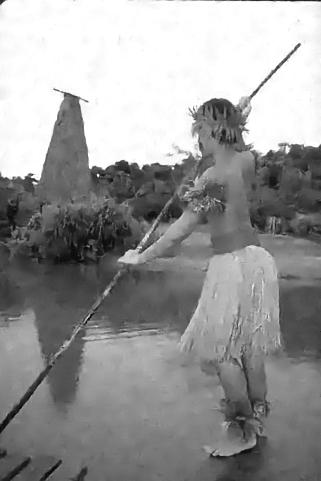
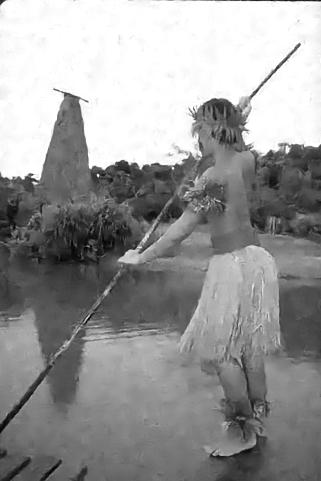
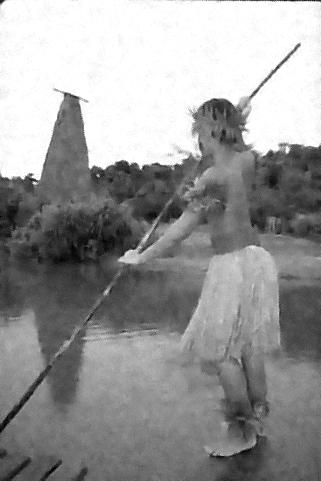
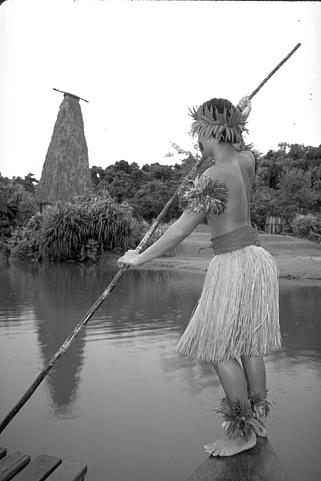
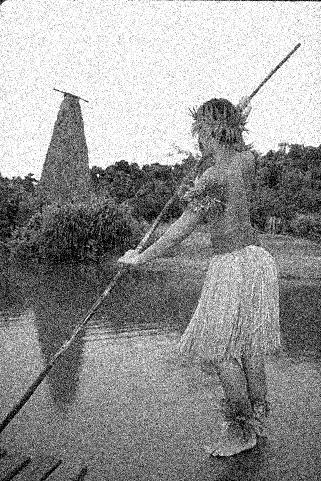

In [ ]:
# Compare the denoising results

from skimage import io
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip
import numpy as np

# load denoising nets

sigma=30

# load an image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

outs = list()



net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_2000.pt', map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'n2c training - %f (dB)' % (PSNR(out, img_clean)) ) )

net = torch.load('pre-trained-tp2/tiny_DnCNN_n2n_l1_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append((out, 'n2n training -  = %f' % PSNR(out, img_clean)))
 
net = torch.load('pre-trained-tp2/tiny_DnCNN_n2s_l1_8000.pt', map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'n2s training -  %f (dB)' % (PSNR(out, img_clean)) ) ) 

outs.append( (np.array(img_clean).clip(0,255), 'clean'))
outs.append( (np.array(img_noisy).clip(0,255), 'noisy'))

vistools.display_gallery(unzip(outs,0), unzip(outs,1))

<font color='blue'>**Question 4.** 

Comment the above result. Is the result better than noise2noise?  Why? </font> 

<font color='red'>**ANSWER TO QUESTION 4.**</font>

No, the results are not as good as in noise2noise. In the case of mean preserving noise, we've seen that noise2noise will achieve similar results as noise2clean. However, noise2self has a performance gap with the former, because the estimator that the model is computing is conditioned on less information (because of the blindspot). Another way to think of the gap is that noise2self is optimizing the noise2clean risk with a constraint on the class of possible functions (only using J-invariant functions), thus the optimal value will be higher. (Eqs. 3.28 and 3.29 of the course notes)

<font color='blue'>**Question 5.** 
Explain and implement the strategy we saw in the theory course to improve the result of noise2self for AWGN.

<!-- Suppose that the noise is Gaussian. In this case, propose and implement a strategy to improve the result of noise2self.-->
</font> 

<font color='red'>**ANSWER TO QUESTION 5.**</font>

Given that the noise is AWGN, we have that this noise is mean preserving and also spatially independent. Then we can apply the strategy presented on section 3.3.2 "Adding some noise back" of the notes. We combine the output of the J-invariant network with the noisy image using a convex combination with a factor $\lambda$. In this setting it's possible to prove that the optimal value for $\lambda$ is $\frac{\sigma^2}{R_{n2s}(F(v), v)}$

This way we can expect to improve a little the performance and be able to reconstruct some small details that are lost when reconstructing the masked pixel with its surroundings.

Unfortunately, I'm not getting the results I expected. The $\lambda$ computed in practice by using the mean of the loss as an estimator of the risk, is greater than 1. One possible explanation is that the equality that holds in expectation between $R_{n2s}$ and $R_{n2c}$, does not hold in this particular realization.

lambda:  1.7096438493032817


Text(0.5, 1.0, 'Original result | PSNR:26.436419555130485')

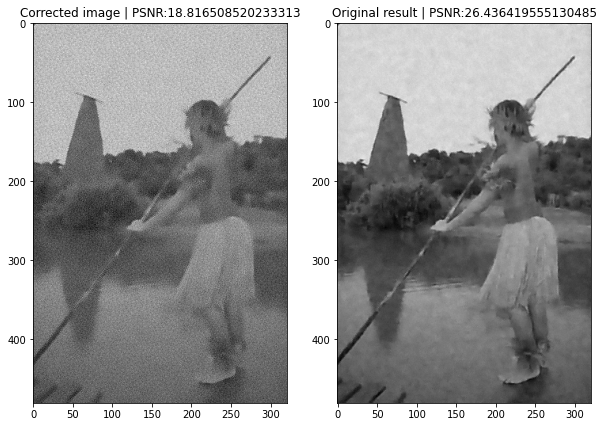

In [ ]:
emp_risk = np.array([l.cpu().item() for l in losst[-10:]]).mean()
net = torch.load('pre-trained-tp2/tiny_DnCNN_n2s_l1_8000.pt', map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0].cpu().numpy()

lambd =  (sigma/ 255)**2 / emp_risk

print("lambda: ", lambd)

corrected = img_noisy * (1-lambd) + out * lambd

psnr_out = PSNR(img_clean, out)

psnr_corrected = PSNR(img_clean, corrected)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(np.squeeze(corrected), cmap='gray')
plt.title(f"Corrected image | PSNR:{psnr_corrected}")
plt.subplot(122)
plt.imshow(np.squeeze(out), cmap='gray')
plt.title(f"Original result | PSNR:{psnr_out}")